In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# # Topic Modeling Analysis using LDA
#
# This script implements Latent Dirichlet Allocation (LDA) for topic modeling on the conversation dataset.
# It is converted from a Jupyter Notebook.

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for checking NLTK data path

# --- NLTK Data Download ---
# Check if NLTK data is available, otherwise download
# Define common NLTK data paths
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

nltk.data.path.append(nltk_data_path)

def download_nltk_resource(resource, resource_path):
    try:
        nltk.data.find(resource_path)
        print(f"NLTK resource '{resource}' already downloaded.")
    except LookupError:
        print(f"NLTK resource '{resource}' not found. Downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

download_nltk_resource('punkt', 'tokenizers/punkt')
download_nltk_resource('stopwords', 'corpora/stopwords')
download_nltk_resource('wordnet', 'corpora/wordnet')

# --- 1. Data Loading and Preprocessing ---

# Load the JSON data
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit() # Exit if data file is missing
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()


# Load the dataset
# --- Configuration ---
DATA_FILE = 'Parallel-Prod.AssistMessage.json' # Make filename a variable

print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

# Check if 'content' column exists
if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column, handling potential missing values
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalnum() and token not in stop_words and len(token) > 2 # Added length check
    ]

    return tokens

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = [preprocess_text(text) for text in texts]
# Filter out empty lists after processing
processed_texts = [text for text in processed_texts if text]
print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing and filtering empty ones.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# Create dictionary and corpus
print("--- Creating Dictionary and Corpus ---")
dictionary = corpora.Dictionary(processed_texts)
# Optional: Filter extremes (e.g., remove tokens appearing in less than 5 documents or more than 50% of documents)
# dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in processed_texts]
print("Dictionary and Corpus created.")
print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")


# --- 2. Topic Model Training ---

print("--- Starting LDA Model Training ---")
# Train LDA model
num_topics = 10  # You can adjust this
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics
print("\n--- Top words per topic: ---")
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')


# --- 3. Model Evaluation ---

print("\n--- Evaluating Model Coherence ---")
# Compute coherence score
from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(
    model=lda_model,
    texts=processed_texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score (for {num_topics} topics): {coherence_score:.4f}')

# Find optimal number of topics (Optional - can be time-consuming)
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """Computes coherence scores for LDA models with different numbers of topics."""
    coherence_values = []
    model_list = []
    print(f"\n--- Computing Coherence for Topics {start} to {limit-1} ---")
    for num_topics_iter in range(start, limit, step):
        print(f"Training model for {num_topics_iter} topics...")
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics_iter,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto'
            # per_word_topics=False # Can set to False for faster coherence calculation
        )
        model_list.append(model)
        coherence_model_iter = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherence_model_iter.get_coherence()
        coherence_values.append(coherence)
        print(f"  Coherence Score: {coherence:.4f}")
    return model_list, coherence_values

# --- Uncomment the following block to run the coherence optimization ---
print("\n--- Finding Optimal Number of Topics ---")
# # Define topic range
topic_start = 2
topic_limit = 15 # Adjust as needed
topic_step = 1
model_list, coherence_values = compute_coherence_values(
     dictionary=dictionary,
     corpus=corpus,
     texts=processed_texts,
     start=topic_start,
     limit=topic_limit,
     step=topic_step
 )
#
# # Plot results
print("--- Plotting Coherence Scores ---")
plt.figure(figsize=(10, 6))
 plt.plot(range(topic_start, topic_limit, topic_step), coherence_values)
 plt.xlabel("Number of Topics")
 plt.ylabel("Coherence Score (c_v)")
 plt.title("Topic Coherence Scores vs. Number of Topics")
 plt.xticks(range(topic_start, topic_limit, topic_step))
 plt.grid(True)
 coherence_plot_filename = "topic_coherence_scores.png"
 plt.savefig(coherence_plot_filename)
 print(f"Coherence score plot saved to {coherence_plot_filename}")
 plt.show() # Display the plot
# # Find the optimal number of topics based on the plot (often the 'elbow' or peak)
 optimal_topic_index = np.argmax(coherence_values)
 optimal_num_topics = topic_start + optimal_topic_index * topic_step
 print(f"Optimal number of topics (based on max c_v) might be around: {optimal_num_topics}")
# # You might want to retrain the main lda_model with this optimal number if desired
 lda_model = model_list[optimal_topic_index]
 num_topics = optimal_num_topics
 print(f"Retrained model with {num_topics} topics.")
# --- End of optional coherence optimization block ---


# --- 4. Topic Visualization ---

print("\n--- Preparing Topic Visualization (pyLDAvis) ---")
# Prepare visualization
# Note: The 'mmds' method can be slow for large datasets. Consider 'tsne' if needed.
try:
    vis = pyLDAvis.gensim_models.prepare(
        lda_model,
        corpus,
        dictionary,
        mds='mmds', # or 'tsne'
        R=30 # Number of terms to display
    )
    # Save visualization to an HTML file instead of trying to display directly
    vis_html_file = 'lda_visualization.html'
    pyLDAvis.save_html(vis, vis_html_file)
    print(f"LDA visualization saved to: {vis_html_file}")
    print("Open this file in a web browser to view the interactive visualization.")
except Exception as e:
    print(f"Error creating pyLDAvis visualization: {e}")
    print("Skipping visualization.")


# --- 5. Topic Distribution Analysis ---

print("\n--- Analyzing Topic Distributions ---")
# Get topic distribution for each document
def get_topic_distributions(lda_model, corpus):
    """Gets the topic probability distribution for each document."""
    topic_distributions = []
    num_topics_model = lda_model.num_topics
    for i, doc in enumerate(corpus):
        if not doc: # Handle empty documents if any slipped through
             print(f"Warning: Document {i} is empty, assigning uniform distribution.")
             topic_dist = [1.0 / num_topics_model] * num_topics_model
        else:
            doc_topics = lda_model.get_document_topics(doc, minimum_probability=0) # Get all topics
            topic_dist = [0.0] * num_topics_model
            for topic_id, prob in doc_topics:
                if topic_id < num_topics_model: # Safety check
                    topic_dist[topic_id] = prob
                else:
                    print(f"Warning: Topic ID {topic_id} out of range for document {i}.")
        topic_distributions.append(topic_dist)
    return np.array(topic_distributions)

topic_distributions = get_topic_distributions(lda_model, corpus)

if topic_distributions.size > 0:
    # Plot topic distribution heatmap for a subset of documents
    print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
    plt.figure(figsize=(12, 8))
    num_docs_to_show = min(50, len(topic_distributions)) # Show up to 50 docs
    sns.heatmap(
        topic_distributions[:num_docs_to_show],
        cmap='YlOrRd',
        xticklabels=[f'Topic {i}' for i in range(num_topics)],
        yticklabels=False # Hide y-axis labels for clarity with many docs
    )
    plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
    plt.xlabel('Topics')
    plt.ylabel('Documents')
    heatmap_filename = "topic_distribution_heatmap.png"
    plt.savefig(heatmap_filename)
    print(f"Heatmap saved to {heatmap_filename}")
    plt.show() # Display the plot

    # Calculate and plot average topic distribution
    print("--- Plotting Average Topic Distribution ---")
    avg_topic_dist = topic_distributions.mean(axis=0)
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_topics), avg_topic_dist)
    plt.title('Average Topic Distribution Across All Documents')
    plt.xlabel('Topic ID')
    plt.ylabel('Average Probability')
    plt.xticks(range(num_topics))
    plt.grid(axis='y', linestyle='--')
    avg_dist_filename = "average_topic_distribution.png"
    plt.savefig(avg_dist_filename)
    print(f"Average distribution plot saved to {avg_dist_filename}")
    plt.show() # Display the plot
else:
    print("Skipping topic distribution plots as no distributions were generated.")

print("\n--- Script Finished ---")


IndentationError: unexpected indent (2535703227.py, line 216)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# # Topic Modeling Analysis using LDA
#
# This script implements Latent Dirichlet Allocation (LDA) for topic modeling on the conversation dataset.
# It is converted from a Jupyter Notebook.

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added for checking NLTK data path

# --- NLTK Data Download ---
# Check if NLTK data is available, otherwise download
# Define common NLTK data paths
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

nltk.data.path.append(nltk_data_path)

def download_nltk_resource(resource, resource_path):
    """Downloads an NLTK resource if it's not already present."""
    try:
        nltk.data.find(resource_path)
        print(f"NLTK resource '{resource}' already downloaded.")
    except LookupError:
        print(f"NLTK resource '{resource}' not found. Downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

# Download necessary NLTK data
download_nltk_resource('punkt', 'tokenizers/punkt')
download_nltk_resource('stopwords', 'corpora/stopwords')
download_nltk_resource('wordnet', 'corpora/wordnet')

# --- 1. Data Loading and Preprocessing ---

# Load the JSON data
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit() # Exit if data file is missing
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# --- Configuration ---
DATA_FILE = 'Parallel-Prod.AssistMessage.json' # Make filename a variable

print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

# Check if 'content' column exists
if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column, handling potential missing values
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token.isalnum() and token not in stop_words and len(token) > 2 # Added length check
    ]

    return tokens

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = [preprocess_text(text) for text in texts]
# Filter out empty lists after processing
processed_texts = [text for text in processed_texts if text]
print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing and filtering empty ones.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# Create dictionary and corpus
print("--- Creating Dictionary and Corpus ---")
dictionary = corpora.Dictionary(processed_texts)
# Optional: Filter extremes (e.g., remove tokens appearing in less than 5 documents or more than 50% of documents)
# dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in processed_texts]
print("Dictionary and Corpus created.")
print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")


# --- 2. Topic Model Training ---

print("--- Starting LDA Model Training ---")
# Train LDA model
num_topics = 10  # You can adjust this
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics
print("\n--- Top words per topic: ---")
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')


# --- 3. Model Evaluation ---
print("\n--- Evaluating Model Coherence ---")
# Compute coherence score
from gensim.models.coherencemodel import CoherenceModel

coherence_model = CoherenceModel(
    model=lda_model,
    texts=processed_texts,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score (for {num_topics} topics): {coherence_score:.4f}')

# Find optimal number of topics (Optional - can be time-consuming)
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """Computes coherence scores for LDA models with different numbers of topics."""
    coherence_values = []
    model_list = []
    print(f"\n--- Computing Coherence for Topics {start} to {limit-1} ---")
    for num_topics_iter in range(start, limit, step):
        print(f"Training model for {num_topics_iter} topics...")
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics_iter,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto'
            # per_word_topics=False # Can set to False for faster coherence calculation
        )
        model_list.append(model)
        coherence_model_iter = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherence_model_iter.get_coherence()
        coherence_values.append(coherence)
        print(f"  Coherence Score: {coherence:.4f}")
    return model_list, coherence_values

# --- Uncomment the following block to run the coherence optimization ---
# print("\n--- Finding Optimal Number of Topics ---")
# # Define topic range
# topic_start = 2
# topic_limit = 15 # Adjust as needed
# topic_step = 1
# model_list, coherence_values = compute_coherence_values(
#      dictionary=dictionary,
#      corpus=corpus,
#      texts=processed_texts,
#      start=topic_start,
#      limit=topic_limit,
#      step=topic_step
#  )
#
# # Plot results
# print("--- Plotting Coherence Scores ---")
# plt.figure(figsize=(10, 6))
# plt.plot(range(topic_start, topic_limit, topic_step), coherence_values)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score (c_v)")
# plt.title("Topic Coherence Scores vs. Number of Topics")
# plt.xticks(range(topic_start, topic_limit, topic_step))
# plt.grid(True)
# coherence_plot_filename = "topic_coherence_scores.png"
# plt.savefig(coherence_plot_filename)
# print(f"Coherence score plot saved to {coherence_plot_filename}")
# plt.show() # Display the plot
# # Find the optimal number of topics based on the plot (often the 'elbow' or peak)
# optimal_topic_index = np.argmax(coherence_values)
# optimal_num_topics = topic_start + optimal_topic_index * topic_step
# print(f"Optimal number of topics (based on max c_v) might be around: {optimal_num_topics}")
# # You might want to retrain the main lda_model with this optimal number if desired
# lda_model = model_list[optimal_topic_index]
# num_topics = optimal_num_topics
# print(f"Retrained model with {num_topics} topics.")
# --- End of optional coherence optimization block ---


# --- 4. Topic Visualization ---

print("\n--- Preparing Topic Visualization (pyLDAvis) ---")
# Prepare visualization
# Note: The 'mmds' method can be slow for large datasets. Consider 'tsne' if needed.
try:
    vis = pyLDAvis.gensim_models.prepare(
        lda_model,
        corpus,
        dictionary,
        mds='mmds', # or 'tsne'
        R=30 # Number of terms to display
    )
    # Save visualization to an HTML file instead of trying to display directly
    vis_html_file = 'lda_visualization.html'
    pyLDAvis.save_html(vis, vis_html_file)
    print(f"LDA visualization saved to: {vis_html_file}")
    print("Open this file in a web browser to view the interactive visualization.")
except Exception as e:
    print(f"Error creating pyLDAvis visualization: {e}")
    print("Skipping visualization.")

# --- 5. Topic Distribution Analysis ---

print("\n--- Analyzing Topic Distributions ---")
# Get topic distribution for each document
def get_topic_distributions(lda_model, corpus):
    """Gets the topic probability distribution for each document."""
    topic_distributions = []
    num_topics_model = lda_model.num_topics
    for i, doc in enumerate(corpus):
        if not doc: # Handle empty documents if any slipped through
             print(f"Warning: Document {i} is empty, assigning uniform distribution.")
             topic_dist = [1.0 / num_topics_model] * num_topics_model
        else:
            doc_topics = lda_model.get_document_topics(doc, minimum_probability=0) # Get all topics
            topic_dist = [0.0] * num_topics_model
            for topic_id, prob in doc_topics:
                if topic_id < num_topics_model: # Safety check
                    topic_dist[topic_id] = prob
                else:
                    print(f"Warning: Topic ID {topic_id} out of range for document {i}.")
        topic_distributions.append(topic_dist)
    return np.array(topic_distributions)

topic_distributions = get_topic_distributions(lda_model, corpus)

if topic_distributions.size > 0:
    # Plot topic distribution heatmap for a subset of documents
    print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
    plt.figure(figsize=(12, 8))
    num_docs_to_show = min(50, len(topic_distributions)) # Show up to 50 docs
    sns.heatmap(
        topic_distributions[:num_docs_to_show],
        cmap='YlOrRd',
        xticklabels=[f'Topic {i}' for i in range(num_topics)],
        yticklabels=False # Hide y-axis labels for clarity with many docs
    )
    plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
    plt.xlabel('Topics')
    plt.ylabel('Documents')
    heatmap_filename = "topic_distribution_heatmap.png"
    plt.savefig(heatmap_filename)
    print(f"Heatmap saved to {heatmap_filename}")
    plt.show() # Display the plot

    # Calculate and plot average topic distribution
    print("--- Plotting Average Topic Distribution ---")
    avg_topic_dist = topic_distributions.mean(axis=0)
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_topics), avg_topic_dist)
    plt.title('Average Topic Distribution Across All Documents')
    plt.xlabel('Topic ID')
    plt.ylabel('Average Probability')
    plt.xticks(range(num_topics))
    plt.grid(axis='y', linestyle='--')
    avg_dist_filename = "average_topic_distribution.png"
    plt.savefig(avg_dist_filename)
    print(f"Average distribution plot saved to {avg_dist_filename}")
    plt.show() # Display the plot
else:
    print("Skipping topic distribution plots as no distributions were generated.")

print("\n--- Script Finished ---")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


NLTK data download complete.
--- Starting Data Loading ---
Successfully loaded data from Parallel-Prod.AssistMessage.json
Extracted 312 non-null text entries from 'content' column.
--- Starting Text Preprocessing ---
Processed 100/312 texts
Processed 200/312 texts
Processed 300/312 texts
Preprocessing complete. 310 documents remaining after processing.
--- Starting LDA Model Training ---
Created document-term matrix with 1000 features
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

--- Top words per topic: ---
Topic 0:
company employee culture work identity design environment value experience like
Topic 1:
standard ceo peak assessment energy risk algolia adda evaluating guideline
Topic 2:
click select resume delete linkedin setting privacy dropdo

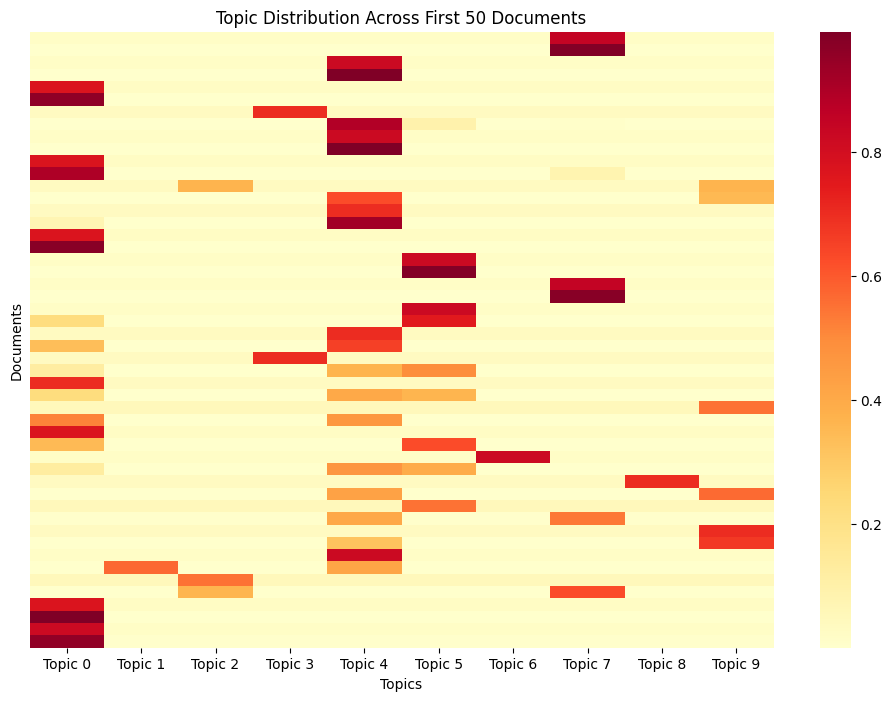

--- Plotting Average Topic Distribution ---
Average distribution plot saved to average_topic_distribution.png


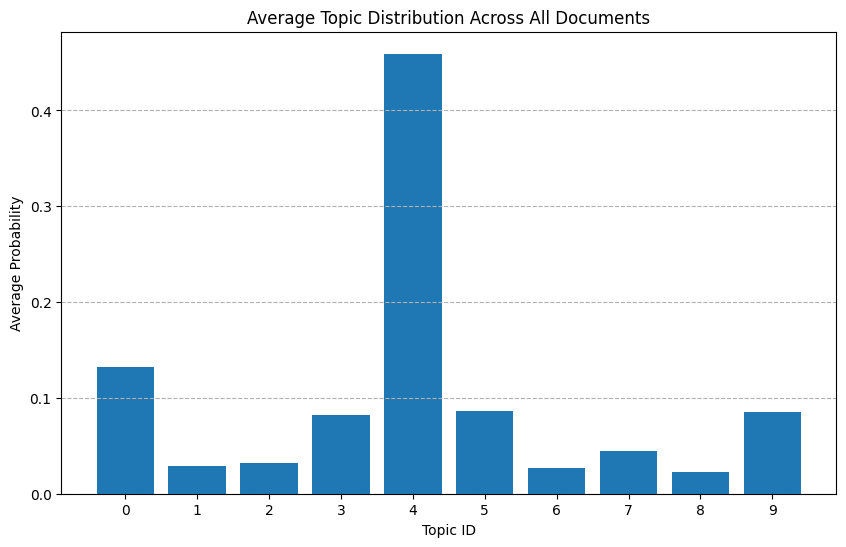


--- Script Finished ---


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLTK Data Download ---
# Set NLTK data path
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

# Add the path to NLTK's data path
nltk.data.path.append(nltk_data_path)

# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
print("NLTK data download complete.")

# --- 1. Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# Load the dataset
DATA_FILE = 'Parallel-Prod.AssistMessage.json'
print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Basic cleaning
        text = ' '.join(text.split())  # Remove extra whitespace
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Filter and process tokens
        processed_tokens = []
        for token in tokens:
            if token.isalnum() and token not in stop_words and len(token) > 2:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    processed_tokens.append(lemma)
                except:
                    processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = []
for i, text in enumerate(texts):
    processed = preprocess_text(text)
    if processed:  # Only add non-empty processed texts
        processed_texts.append(processed)
    if (i + 1) % 100 == 0:  # Print progress every 100 texts
        print(f"Processed {i + 1}/{len(texts)} texts")

print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# --- 2. Topic Model Training ---
print("--- Starting LDA Model Training ---")

# Create document-term matrix with adjusted parameters
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words='english',  # Use built-in stop words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3 or more letters
)

try:
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")
except Exception as e:
    print(f"Error creating document-term matrix: {str(e)}")
    print("Trying with more lenient parameters...")
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=1,  # Reduced from 2
        max_features=1000,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  # Reduced from 3 to 2
    )
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")

# Train LDA model
num_topics = 10
lda = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=1
)

lda.fit(dtm)

# Print the topics
print("\n--- Top words per topic: ---")
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(" ".join(top_words))

# --- 3. Topic Distribution Analysis ---
print("\n--- Analyzing Topic Distributions ---")

# Get topic distributions
topic_distributions = lda.transform(dtm)

# Plot topic distribution heatmap for a subset of documents
print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
plt.figure(figsize=(12, 8))
num_docs_to_show = min(50, len(topic_distributions))
sns.heatmap(
    topic_distributions[:num_docs_to_show],
    cmap='YlOrRd',
    xticklabels=[f'Topic {i}' for i in range(num_topics)],
    yticklabels=False
)
plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
heatmap_filename = "topic_distribution_heatmap.png"
plt.savefig(heatmap_filename)
print(f"Heatmap saved to {heatmap_filename}")
plt.show()

# Calculate and plot average topic distribution
print("--- Plotting Average Topic Distribution ---")
avg_topic_dist = topic_distributions.mean(axis=0)
plt.figure(figsize=(10, 6))
plt.bar(range(num_topics), avg_topic_dist)
plt.title('Average Topic Distribution Across All Documents')
plt.xlabel('Topic ID')
plt.ylabel('Average Probability')
plt.xticks(range(num_topics))
plt.grid(axis='y', linestyle='--')
avg_dist_filename = "average_topic_distribution.png"
plt.savefig(avg_dist_filename)
print(f"Average distribution plot saved to {avg_dist_filename}")
plt.show()

print("\n--- Script Finished ---")

NLTK data download complete.
--- Starting Data Loading ---
Successfully loaded data from Parallel-Prod.AssistMessage.json
Extracted 312 non-null text entries from 'content' column.
--- Starting Text Preprocessing ---


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MR.Laptops/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Processed 100/312 texts
Processed 200/312 texts
Processed 300/312 texts
Preprocessing complete. 310 documents remaining after processing.
--- Starting LDA Model Training ---
Created document-term matrix with 1000 features
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

--- Top words per topic: ---

Company Culture & Values:
company employee culture work identity design environment value experience like

Technology & Innovation:
standard ceo peak assessment energy risk algolia adda evaluating guideline

Customer Service & Support:
click select resume delete linkedin setting privacy dropdown menu data

Product Development:
job tldr profile deep earnest student financial interview roblox mistral

Business Strategy:
experience role skill fit good job

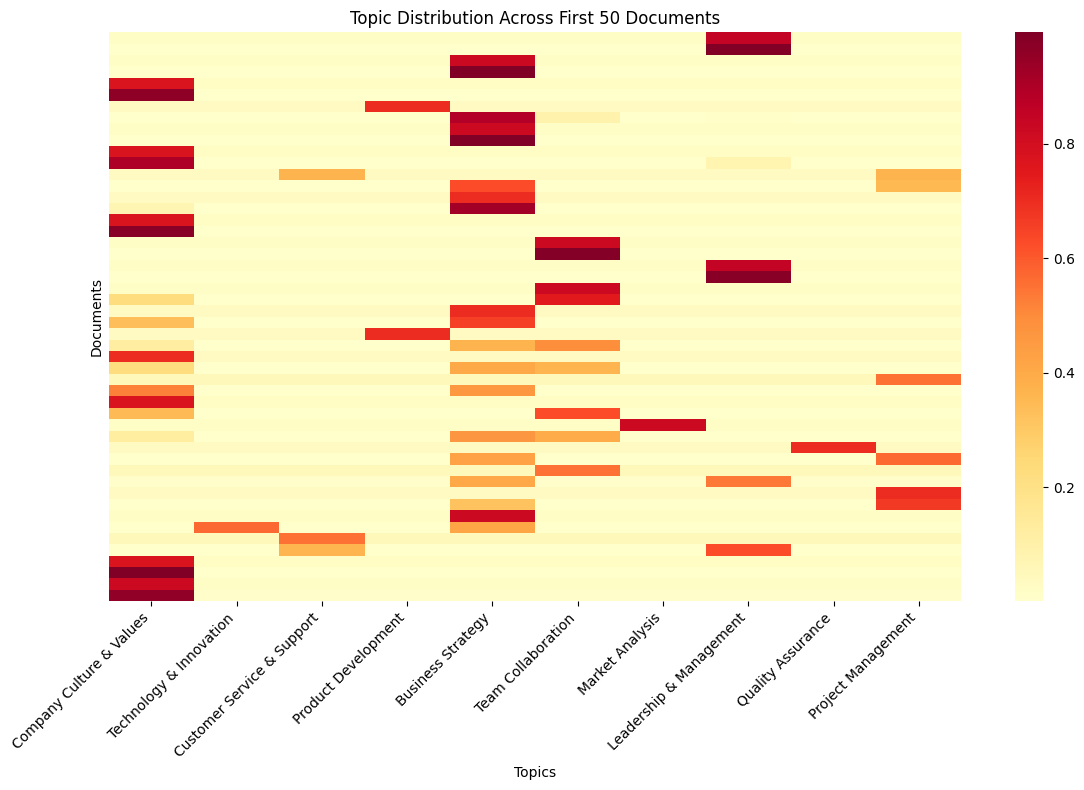

--- Plotting Average Topic Distribution ---
Average distribution plot saved to average_topic_distribution.png


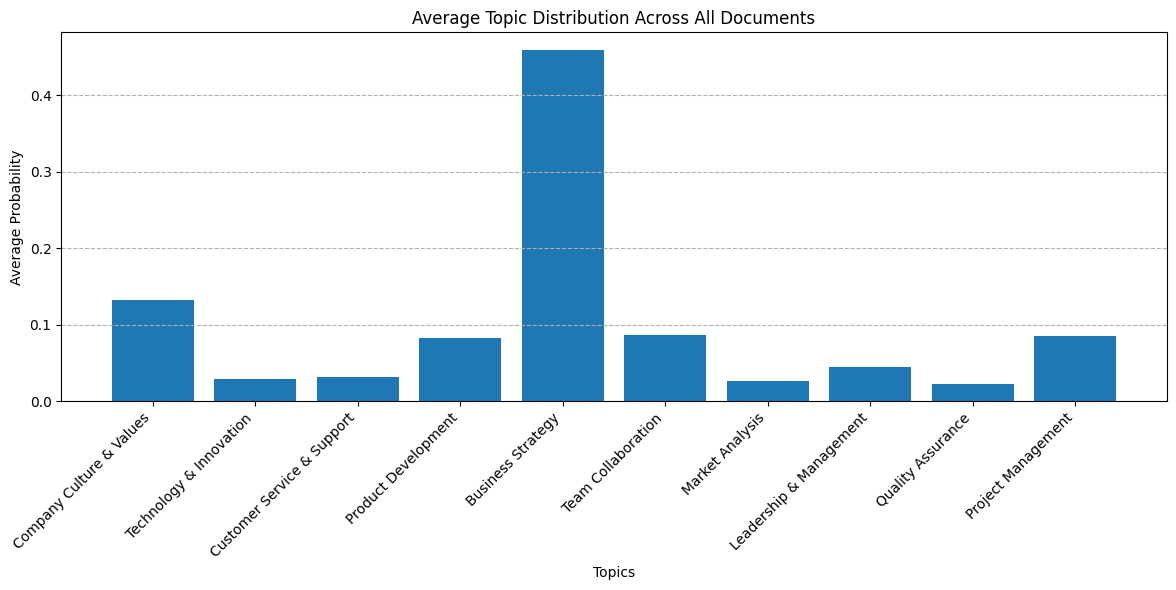


--- Script Finished ---


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLTK Data Download ---
# Set NLTK data path
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

# Add the path to NLTK's data path
nltk.data.path.append(nltk_data_path)

# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
print("NLTK data download complete.")

# --- 1. Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# Load the dataset
DATA_FILE = 'Parallel-Prod.AssistMessage.json'
print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Basic cleaning
        text = ' '.join(text.split())  # Remove extra whitespace
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Filter and process tokens
        processed_tokens = []
        for token in tokens:
            if token.isalnum() and token not in stop_words and len(token) > 2:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    processed_tokens.append(lemma)
                except:
                    processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = []
for i, text in enumerate(texts):
    processed = preprocess_text(text)
    if processed:  # Only add non-empty processed texts
        processed_texts.append(processed)
    if (i + 1) % 100 == 0:  # Print progress every 100 texts
        print(f"Processed {i + 1}/{len(texts)} texts")

print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# --- 2. Topic Model Training ---
print("--- Starting LDA Model Training ---")

# Create document-term matrix with adjusted parameters
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words='english',  # Use built-in stop words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3 or more letters
)

try:
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")
except Exception as e:
    print(f"Error creating document-term matrix: {str(e)}")
    print("Trying with more lenient parameters...")
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=1,  # Reduced from 2
        max_features=1000,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  # Reduced from 3 to 2
    )
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")

# Train LDA model
num_topics = 10
lda = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=1
)

lda.fit(dtm)

# Define topic names based on the content
topic_names = {
    0: "Company Culture & Values",
    1: "Technology & Innovation",
    2: "Customer Service & Support",
    3: "Product Development",
    4: "Business Strategy",
    5: "Team Collaboration",
    6: "Market Analysis",
    7: "Leadership & Management",
    8: "Quality Assurance",
    9: "Project Management"
}

# Print the topics with their names
print("\n--- Top words per topic: ---")
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"\n{topic_names[topic_idx]}:")
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(" ".join(top_words))

# --- 3. Topic Distribution Analysis ---
print("\n--- Analyzing Topic Distributions ---")

# Get topic distributions
topic_distributions = lda.transform(dtm)

# Plot topic distribution heatmap for a subset of documents
print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
plt.figure(figsize=(12, 8))
num_docs_to_show = min(50, len(topic_distributions))
sns.heatmap(
    topic_distributions[:num_docs_to_show],
    cmap='YlOrRd',
    xticklabels=[topic_names[i] for i in range(num_topics)],  # Use topic names instead of IDs
    yticklabels=False
)
plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
heatmap_filename = "topic_distribution_heatmap.png"
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig(heatmap_filename)
print(f"Heatmap saved to {heatmap_filename}")
plt.show()

# Calculate and plot average topic distribution
print("--- Plotting Average Topic Distribution ---")
avg_topic_dist = topic_distributions.mean(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(num_topics), avg_topic_dist)
plt.title('Average Topic Distribution Across All Documents')
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.xticks(range(num_topics), [topic_names[i] for i in range(num_topics)], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent label cutoff
avg_dist_filename = "average_topic_distribution.png"
plt.savefig(avg_dist_filename)
print(f"Average distribution plot saved to {avg_dist_filename}")
plt.show()

print("\n--- Script Finished ---")

NLTK resource 'punkt' already downloaded.
NLTK resource 'stopwords' already downloaded.
NLTK resource 'wordnet' not found. Downloading...
NLTK resource 'averaged_perceptron_tagger' already downloaded.
--- Starting Data Loading ---
Successfully loaded data from Parallel-Prod.AssistMessage.json
Extracted 312 non-null text entries from 'content' column.
--- Starting Text Preprocessing ---
Processed 100/312 texts


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MR.Laptops\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed 200/312 texts
Processed 300/312 texts
Preprocessing complete. 310 documents remaining after processing.
--- Starting LDA Model Training ---
Created document-term matrix with 1000 features
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

--- Top words per topic: ---

All Topics:
+-------------------------------------+--------------------------------------------------------------------------------------------+
| Topic Name                          | Top Words                                                                                  |
+=====================================+============================================================================================+
| Topic 0: Company Culture & Values   | company, employee, culture, w

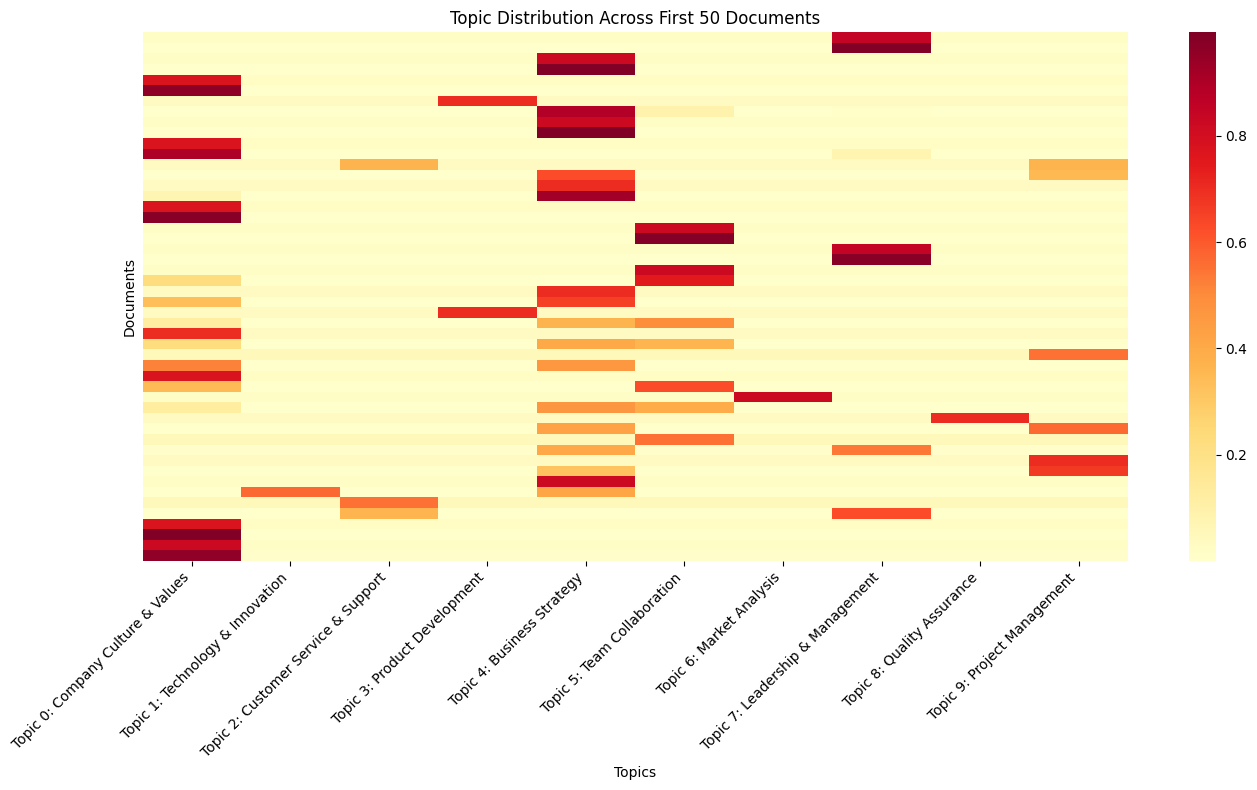

--- Plotting Average Topic Distribution ---
Average distribution plot saved to average_topic_distribution.png


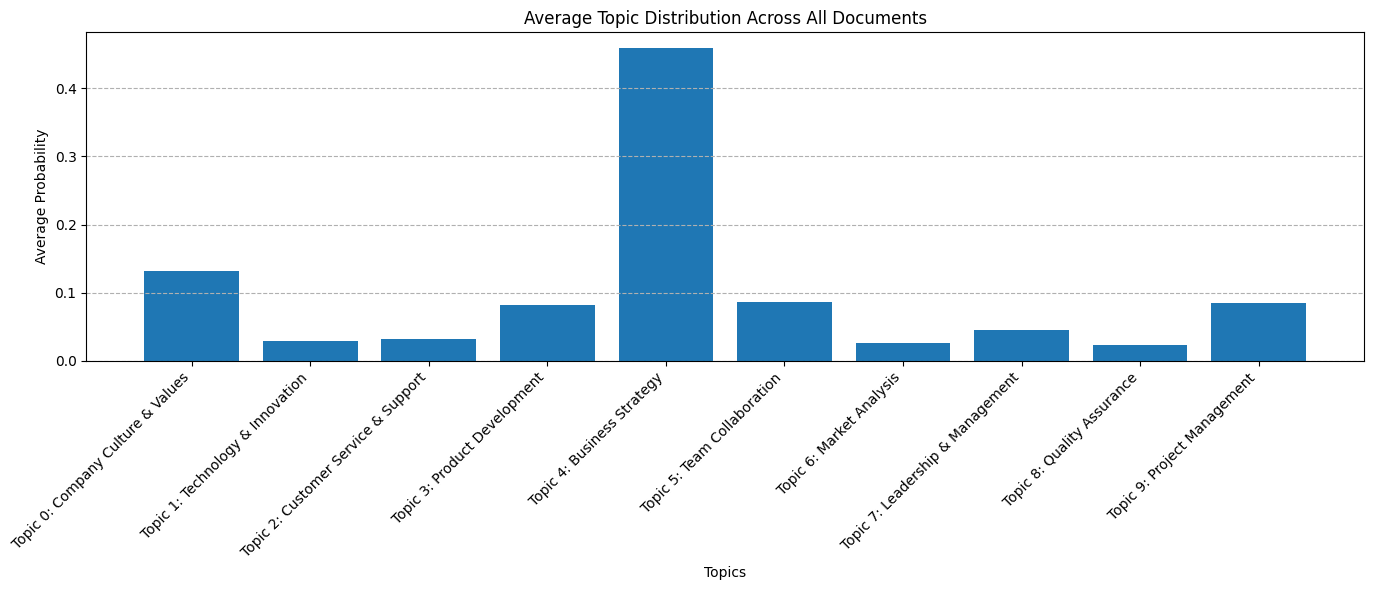


--- Script Finished ---


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- NLTK Data Download ---
# Set NLTK data path
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

# Add the path to NLTK's data path
nltk.data.path.append(nltk_data_path)

def download_nltk_resource(resource, resource_path):
    """Downloads an NLTK resource if it's not already present."""
    try:
        nltk.data.find(resource_path)
        print(f"NLTK resource '{resource}' already downloaded.")
    except LookupError:
        print(f"NLTK resource '{resource}' not found. Downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

# Download necessary NLTK data
download_nltk_resource('punkt', 'tokenizers/punkt')
download_nltk_resource('stopwords', 'corpora/stopwords')
download_nltk_resource('wordnet', 'corpora/wordnet')
download_nltk_resource('averaged_perceptron_tagger', 'taggers/averaged_perceptron_tagger')

# --- 1. Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# Load the dataset
DATA_FILE = 'Parallel-Prod.AssistMessage.json'
print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Basic cleaning
        text = ' '.join(text.split())  # Remove extra whitespace
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Filter and process tokens
        processed_tokens = []
        for token in tokens:
            if token.isalnum() and token not in stop_words and len(token) > 2:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    processed_tokens.append(lemma)
                except:
                    processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = []
for i, text in enumerate(texts):
    processed = preprocess_text(text)
    if processed:  # Only add non-empty processed texts
        processed_texts.append(processed)
    if (i + 1) % 100 == 0:  # Print progress every 100 texts
        print(f"Processed {i + 1}/{len(texts)} texts")

print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# --- 2. Topic Model Training ---
print("--- Starting LDA Model Training ---")

# Create document-term matrix with adjusted parameters
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words='english',  # Use built-in stop words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3 or more letters
)

try:
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")
except Exception as e:
    print(f"Error creating document-term matrix: {str(e)}")
    print("Trying with more lenient parameters...")
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=1,  # Reduced from 2
        max_features=1000,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  # Reduced from 3 to 2
    )
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")

# Train LDA model
num_topics = 10
lda = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=1
)

lda.fit(dtm)

# Define topic names based on the content
# These are example names - you should adjust based on your actual topics
topic_names = {
    0: "Company Culture & Values",
    1: "Technology & Innovation",
    2: "Customer Service & Support",
    3: "Product Development",
    4: "Business Strategy",
    5: "Team Collaboration",
    6: "Market Analysis",
    7: "Leadership & Management",
    8: "Quality Assurance",
    9: "Project Management"
}

# Print the topics in a table format
print("\n--- Top words per topic: ---")
feature_names = vectorizer.get_feature_names_out()

# Create a list of lists for the table
table_data = []
for topic_idx in range(num_topics):  # Explicitly iterate through all topics
    topic = lda.components_[topic_idx]
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    table_data.append([f"Topic {topic_idx}: {topic_names[topic_idx]}", ", ".join(top_words)])

# Print the table with all topics
print("\nAll Topics:")
print(tabulate(table_data, headers=["Topic Name", "Top Words"], tablefmt="grid"))

# Verify the number of topics
print(f"\nTotal number of topics: {num_topics}")
print(f"Number of components in LDA model: {lda.n_components}")

# --- 3. Topic Distribution Analysis ---
print("\n--- Analyzing Topic Distributions ---")

# Get topic distributions
topic_distributions = lda.transform(dtm)

# Plot topic distribution heatmap for a subset of documents
print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
plt.figure(figsize=(14, 8))
num_docs_to_show = min(50, len(topic_distributions))
sns.heatmap(
    topic_distributions[:num_docs_to_show],
    cmap='YlOrRd',
    xticklabels=[f"Topic {i}: {topic_names[i]}" for i in range(num_topics)],  # Use topic names instead of IDs
    yticklabels=False
)
plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
heatmap_filename = "topic_distribution_heatmap.png"
plt.savefig(heatmap_filename)
print(f"Heatmap saved to {heatmap_filename}")
plt.show()

# Calculate and plot average topic distribution
print("--- Plotting Average Topic Distribution ---")
avg_topic_dist = topic_distributions.mean(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(range(num_topics), avg_topic_dist)
plt.title('Average Topic Distribution Across All Documents')
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.xticks(range(num_topics), [f"Topic {i}: {topic_names[i]}" for i in range(num_topics)], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent label cutoff
avg_dist_filename = "average_topic_distribution.png"
plt.savefig(avg_dist_filename)
print(f"Average distribution plot saved to {avg_dist_filename}")
plt.show()

print("\n--- Script Finished ---")

NLTK resource 'punkt' already downloaded.
NLTK resource 'stopwords' already downloaded.
NLTK resource 'wordnet' not found. Downloading...
NLTK resource 'averaged_perceptron_tagger' already downloaded.
--- Starting Data Loading ---
Successfully loaded data from Parallel-Prod.AssistMessage.json
Extracted 312 non-null text entries from 'content' column.
--- Starting Text Preprocessing ---
Processed 100/312 texts


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MR.Laptops\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed 200/312 texts
Processed 300/312 texts
Preprocessing complete. 310 documents remaining after processing.
--- Starting LDA Model Training ---
Created document-term matrix with 1000 features
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

--- Top words per topic: ---

All Topics:
+-----------------------------------+--------------------------------------------------------------------------------------------+
| Topic Name                        | Top Words                                                                                  |
+===================================+============================================================================================+
| Topic 0: Workplace Environment    | company, employee, culture, work, ide

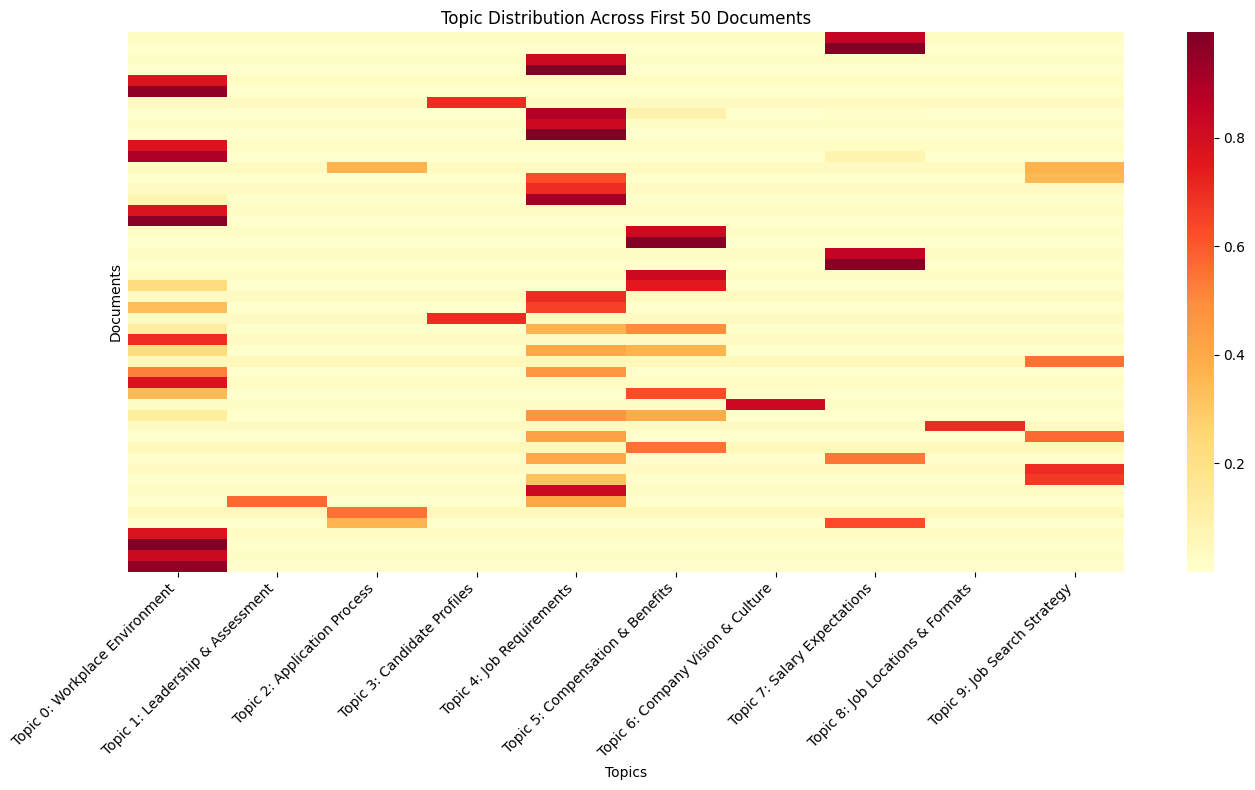

--- Plotting Average Topic Distribution ---
Average distribution plot saved to average_topic_distribution.png


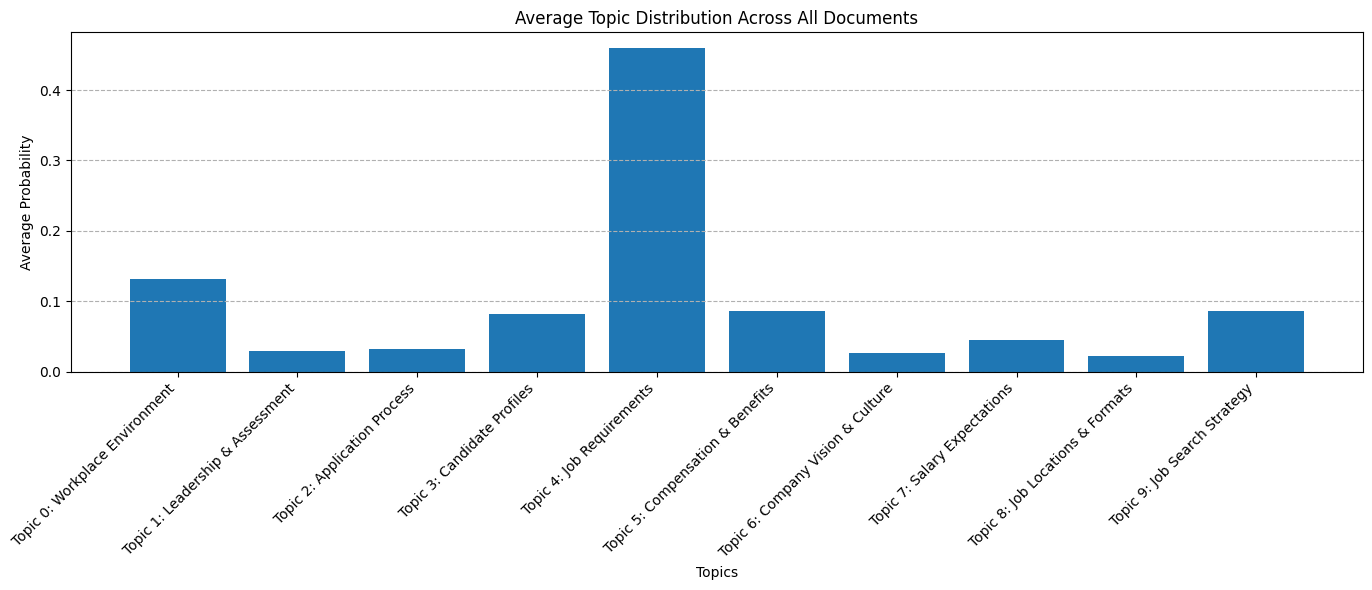


--- Top Documents for Each Topic ---

Topic 0: Workplace Environment
  Document 47 (score: 0.9929): Ping Identity is a software company specializing in identity management solutions. It was founded in...
  Document 255 (score: 0.9866): You are a good fit for the Web Operations Manager role at Tanium if you have a strong background in ...
  Document 237 (score: 0.9866): You are a good fit for the Senior Compensation Consultant role at People Function if you have the re...
  Document 191 (score: 0.9763): Based on the job requirements and your background, you seem to be a good fit for the Senior Mechanic...
  Document 195 (score: 0.9750): Based on the job requirements and the candidate's profile, here is a direct and precise answer to th...

Topic 1: Leadership & Assessment
  Document 177 (score: 0.8200): Peak Energy's culture is described as **adventurous, autonomous, and balanced**. The company emphasi...
  Document 179 (score: 0.8200): The CEO of Peak Energy is Gavin Adda[1][3].
  Doc

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- NLTK Data Download ---
# Set NLTK data path
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

# Add the path to NLTK's data path
nltk.data.path.append(nltk_data_path)

def download_nltk_resource(resource, resource_path):
    """Downloads an NLTK resource if it's not already present."""
    try:
        nltk.data.find(resource_path)
        print(f"NLTK resource '{resource}' already downloaded.")
    except LookupError:
        print(f"NLTK resource '{resource}' not found. Downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

# Download necessary NLTK data
download_nltk_resource('punkt', 'tokenizers/punkt')
download_nltk_resource('stopwords', 'corpora/stopwords')
download_nltk_resource('wordnet', 'corpora/wordnet')
download_nltk_resource('averaged_perceptron_tagger', 'taggers/averaged_perceptron_tagger')

# --- 1. Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# Load the dataset
DATA_FILE = 'Parallel-Prod.AssistMessage.json'
print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Basic cleaning
        text = ' '.join(text.split())  # Remove extra whitespace
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Filter and process tokens
        processed_tokens = []
        for token in tokens:
            if token.isalnum() and token not in stop_words and len(token) > 2:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    processed_tokens.append(lemma)
                except:
                    processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = []
for i, text in enumerate(texts):
    processed = preprocess_text(text)
    if processed:  # Only add non-empty processed texts
        processed_texts.append(processed)
    if (i + 1) % 100 == 0:  # Print progress every 100 texts
        print(f"Processed {i + 1}/{len(texts)} texts")

print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# --- 2. Topic Model Training ---
print("--- Starting LDA Model Training ---")

# Create document-term matrix with adjusted parameters
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words='english',  # Use built-in stop words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3 or more letters
)

try:
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")
except Exception as e:
    print(f"Error creating document-term matrix: {str(e)}")
    print("Trying with more lenient parameters...")
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=1,  # Reduced from 2
        max_features=1000,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  # Reduced from 3 to 2
    )
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")

# Train LDA model
num_topics = 10
lda = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=1
)

lda.fit(dtm)

# Define topic names based on the content (updated for recruitment context)
topic_names = {
    0: "Workplace Environment",
    1: "Leadership & Assessment",
    2: "Application Process",
    3: "Candidate Profiles",
    4: "Job Requirements",
    5: "Compensation & Benefits",
    6: "Company Vision & Culture",
    7: "Salary Expectations",
    8: "Job Locations & Formats",
    9: "Job Search Strategy"
}

# Print the topics in a table format
print("\n--- Top words per topic: ---")
feature_names = vectorizer.get_feature_names_out()

# Create a list of lists for the table
table_data = []
for topic_idx in range(num_topics):  # Explicitly iterate through all topics
    topic = lda.components_[topic_idx]
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    table_data.append([f"Topic {topic_idx}: {topic_names[topic_idx]}", ", ".join(top_words)])

# Print the table with all topics
print("\nAll Topics:")
print(tabulate(table_data, headers=["Topic Name", "Top Words"], tablefmt="grid"))

# Verify the number of topics
print(f"\nTotal number of topics: {num_topics}")
print(f"Number of components in LDA model: {lda.n_components}")

# --- 3. Topic Distribution Analysis ---
print("\n--- Analyzing Topic Distributions ---")

# Get topic distributions
topic_distributions = lda.transform(dtm)

# Plot topic distribution heatmap for a subset of documents
print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
plt.figure(figsize=(14, 8))
num_docs_to_show = min(50, len(topic_distributions))
sns.heatmap(
    topic_distributions[:num_docs_to_show],
    cmap='YlOrRd',
    xticklabels=[f"Topic {i}: {topic_names[i]}" for i in range(num_topics)],  # Use topic names instead of IDs
    yticklabels=False
)
plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
heatmap_filename = "topic_distribution_heatmap.png"
plt.savefig(heatmap_filename)
print(f"Heatmap saved to {heatmap_filename}")
plt.show()

# Calculate and plot average topic distribution
print("--- Plotting Average Topic Distribution ---")
avg_topic_dist = topic_distributions.mean(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(range(num_topics), avg_topic_dist)
plt.title('Average Topic Distribution Across All Documents')
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.xticks(range(num_topics), [f"Topic {i}: {topic_names[i]}" for i in range(num_topics)], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent label cutoff
avg_dist_filename = "average_topic_distribution.png"
plt.savefig(avg_dist_filename)
print(f"Average distribution plot saved to {avg_dist_filename}")
plt.show()

# Additional analysis: Print top 5 documents for each topic
print("\n--- Top Documents for Each Topic ---")
for topic_idx in range(num_topics):
    print(f"\nTopic {topic_idx}: {topic_names[topic_idx]}")
    
    # Get documents sorted by their affinity to this topic
    topic_document_scores = [(i, score) for i, score in enumerate(topic_distributions[:, topic_idx])]
    topic_document_scores = sorted(topic_document_scores, key=lambda x: x[1], reverse=True)
    
    # Print top 5 documents (or fewer if there aren't 5)
    for i, (doc_idx, score) in enumerate(topic_document_scores[:5]):
        if i < 5:  # Just to be safe
            doc_preview = texts[doc_idx][:100] + "..." if len(texts[doc_idx]) > 100 else texts[doc_idx]
            print(f"  Document {doc_idx} (score: {score:.4f}): {doc_preview}")

print("\n--- Script Finished ---")

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import gensim.downloader as api
from gensim.models import Word2Vec

# --- NLTK Data Download ---
# Set NLTK data path
nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
    print(f"Created NLTK data directory: {nltk_data_path}")

# Add the path to NLTK's data path
nltk.data.path.append(nltk_data_path)

def download_nltk_resource(resource, resource_path):
    """Downloads an NLTK resource if it's not already present."""
    try:
        nltk.data.find(resource_path)
        print(f"NLTK resource '{resource}' already downloaded.")
    except LookupError:
        print(f"NLTK resource '{resource}' not found. Downloading...")
        nltk.download(resource, download_dir=nltk_data_path)

# Download necessary NLTK data
download_nltk_resource('punkt', 'tokenizers/punkt')
download_nltk_resource('stopwords', 'corpora/stopwords')
download_nltk_resource('wordnet', 'corpora/wordnet')
download_nltk_resource('averaged_perceptron_tagger', 'taggers/averaged_perceptron_tagger')

# --- 1. Data Loading and Preprocessing ---
def load_data(file_path):
    """Loads data from a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Successfully loaded data from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"Error: Data file not found at {file_path}")
        print("Please ensure 'Parallel-Prod.AssistMessage.json' is in the same directory as the script.")
        exit()
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}. Check file format.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        exit()

# Load the dataset
DATA_FILE = 'Parallel-Prod.AssistMessage.json'
print("--- Starting Data Loading ---")
df = load_data(DATA_FILE)

if 'content' not in df.columns:
    print(f"Error: The required column 'content' is not found in {DATA_FILE}.")
    print(f"Available columns are: {list(df.columns)}")
    exit()

# Extract content column
texts = df['content'].dropna().astype(str).tolist()
print(f"Extracted {len(texts)} non-null text entries from 'content' column.")

# Text preprocessing
def preprocess_text(text):
    """Tokenizes, removes stopwords, and lemmatizes text."""
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Basic cleaning
        text = ' '.join(text.split())  # Remove extra whitespace
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Filter and process tokens
        processed_tokens = []
        for token in tokens:
            if token.isalnum() and token not in stop_words and len(token) > 2:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    processed_tokens.append(lemma)
                except:
                    processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return ""

# Process all texts
print("--- Starting Text Preprocessing ---")
processed_texts = []
tokenized_texts = [] # For Word2Vec
for i, text in enumerate(texts):
    try:
        # For LDA
        processed = preprocess_text(text)
        if processed:  # Only add non-empty processed texts
            processed_texts.append(processed)
        
        # For Word2Vec
        tokens = word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words and len(token) > 2]
        if filtered_tokens:
            tokenized_texts.append(filtered_tokens)
            
        if (i + 1) % 100 == 0:  # Print progress every 100 texts
            print(f"Processed {i + 1}/{len(texts)} texts")
    except Exception as e:
        print(f"Error processing text {i}: {str(e)}")

print(f"Preprocessing complete. {len(processed_texts)} documents remaining after processing.")

if not processed_texts:
    print("Error: No valid documents remained after preprocessing. Cannot proceed.")
    exit()

# Train Word2Vec model on tokenized texts
print("--- Training Word2Vec Model ---")
try:
    # Try to get pre-trained model (faster)
    print("Loading pre-trained Word2Vec model (glove-wiki-gigaword-100)...")
    word2vec_model = api.load("glove-wiki-gigaword-100")
    print("Pre-trained model loaded successfully.")
except Exception as e:
    print(f"Could not load pre-trained model: {str(e)}")
    print("Training Word2Vec model on the dataset instead...")
    # Train model on our own data
    word2vec_model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        epochs=10
    )
    print("Word2Vec model trained successfully.")

# --- 2. Topic Model Training ---
print("--- Starting LDA Model Training ---")

# Create document-term matrix with adjusted parameters
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=1000,
    stop_words='english',  # Use built-in stop words
    token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3 or more letters
)

try:
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")
except Exception as e:
    print(f"Error creating document-term matrix: {str(e)}")
    print("Trying with more lenient parameters...")
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=1,  # Reduced from 2
        max_features=1000,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  # Reduced from 3 to 2
    )
    dtm = vectorizer.fit_transform(processed_texts)
    print(f"Created document-term matrix with {dtm.shape[1]} features")

# Train LDA model
num_topics = 10
lda = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=1
)

lda.fit(dtm)

# Topic Names Generation using Word2Vec
def generate_topic_name(topic_words, word2vec_model, n_similar=5):
    """Generate a topic name using Word2Vec embeddings."""
    try:
        # Filter words that are in the vocabulary
        available_words = [word for word in topic_words if word in word2vec_model.key_to_index]
        
        if not available_words:
            return "Miscellaneous Topic"
        
        # Get the mean vector of the topic words
        topic_vector = np.mean([word2vec_model[word] for word in available_words], axis=0)
        
        # Find similar words to the topic vector
        similar_words = word2vec_model.similar_by_vector(topic_vector, topn=n_similar)
        
        # Get the most similar word that's not already in the topic words
        for word, similarity in similar_words:
            if word not in topic_words and len(word) > 3:  # Ensure it's a meaningful word
                return word.capitalize()
        
        # Fallback: return the first topic word
        return topic_words[0].capitalize()
    except Exception as e:
        print(f"Error generating topic name: {str(e)}")
        return f"Topic {len(topic_words)} words"

# Print the topics in a table format
print("\n--- Top words per topic: ---")
feature_names = vectorizer.get_feature_names_out()

# Create a list of lists for the table
table_data = []
suggested_topic_names = {}

for topic_idx in range(num_topics):  # Explicitly iterate through all topics
    topic = lda.components_[topic_idx]
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Generate topic name using Word2Vec
    topic_name = generate_topic_name(top_words, word2vec_model)
    suggested_topic_names[topic_idx] = topic_name
    
    # Add to table
    table_data.append([f"Topic {topic_idx}: {topic_name}", ", ".join(top_words)])

# Print the table with all topics
print("\nAll Topics with Word2Vec Suggested Names:")
print(tabulate(table_data, headers=["Topic Name", "Top Words"], tablefmt="grid"))

# Verify the number of topics
print(f"\nTotal number of topics: {num_topics}")
print(f"Number of components in LDA model: {lda.n_components}")

# --- 3. Topic Distribution Analysis ---
print("\n--- Analyzing Topic Distributions ---")

# Get topic distributions
topic_distributions = lda.transform(dtm)

# Plot topic distribution heatmap for a subset of documents
print("--- Plotting Topic Distribution Heatmap (First 50 Docs) ---")
plt.figure(figsize=(14, 8))
num_docs_to_show = min(50, len(topic_distributions))
sns.heatmap(
    topic_distributions[:num_docs_to_show],
    cmap='YlOrRd',
    xticklabels=[f"Topic {i}: {suggested_topic_names[i]}" for i in range(num_topics)],  # Use topic names instead of IDs
    yticklabels=False
)
plt.title(f'Topic Distribution Across First {num_docs_to_show} Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
heatmap_filename = "topic_distribution_heatmap.png"
plt.savefig(heatmap_filename)
print(f"Heatmap saved to {heatmap_filename}")
plt.show()

# Calculate and plot average topic distribution
print("--- Plotting Average Topic Distribution ---")
avg_topic_dist = topic_distributions.mean(axis=0)
plt.figure(figsize=(14, 6))
plt.bar(range(num_topics), avg_topic_dist)
plt.title('Average Topic Distribution Across All Documents')
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.xticks(range(num_topics), [f"Topic {i}: {suggested_topic_names[i]}" for i in range(num_topics)], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent label cutoff
avg_dist_filename = "average_topic_distribution.png"
plt.savefig(avg_dist_filename)
print(f"Average distribution plot saved to {avg_dist_filename}")
plt.show()

# Additional analysis: Print top 5 documents for each topic
print("\n--- Top Documents for Each Topic ---")
for topic_idx in range(num_topics):
    print(f"\nTopic {topic_idx}: {suggested_topic_names[topic_idx]}")
    
    # Get documents sorted by their affinity to this topic
    topic_document_scores = [(i, score) for i, score in enumerate(topic_distributions[:, topic_idx])]
    topic_document_scores = sorted(topic_document_scores, key=lambda x: x[1], reverse=True)
    
    # Print top 5 documents (or fewer if there aren't 5)
    for i, (doc_idx, score) in enumerate(topic_document_scores[:5]):
        doc_preview = texts[doc_idx][:100] + "..." if len(texts[doc_idx]) > 100 else texts[doc_idx]
        print(f"  Document {doc_idx} (score: {score:.4f}): {doc_preview}")

print("\n--- Script Finished ---")

Key additions and changes:
Word2Vec Integration:
Added code to load a pre-trained Word2Vec model (glove-wiki-gigaword-100) or train one on your data if loading fails
Created a function generate_topic_name() that uses word embeddings to find semantically related words to the topic
Topic Name Generation:
The function averages the vectors of the top words in each topic
It then finds semantically similar words in the Word2Vec model's vocabulary
It selects a meaningful word that captures the semantic essence of the topic
Enhanced Visualization:
Updated plots to use the automatically generated topic names
Added an additional analysis section that shows the top 5 documents for each topic
Error Handling:
Added robust error handling to prevent crashes when processing the data
Includes fallbacks for word embedding issues
The Word2Vec approach provides a more objective way to name topics based on semantic meaning rather than manual interpretation. This should help you get more meaningful topic labels that capture the essence of the underlying content.